# Named Entity Recognition
@author: Abdullahi S. Adamu

In [1]:
# Handle depencies 

In [2]:
!pip3 install --upgrade pip
# !pip3 install -r requirements.txt

In [3]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

In [4]:
!pip install -q tf-models-official

In [5]:
import os
import shutil
import pandas as pd
from glob import glob
import seaborn as sns
from matplotlib import pylab as plt
import tensorflow as tf
# depenciy handling
if tf.__version__ != '2.3.0':
    !pip install tensorflow-gpu==2.3.0
    
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization 
from google.colab import drive

tf.get_logger().setLevel('ERROR')

In [6]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read Dataset

In [7]:
google_drive_path = '/content/drive/My Drive/sb'

def get_dataset(file_name='./data/data.csv'):
  return pd.read_csv(os.path.join(google_drive_path, file_name))

dataset = get_dataset()

In [8]:
dataset.head()

,Class,Name
0,1,E. D. Abbott Ltd
1,1,Schwan-Stabilo
2,1,Q-workshop
3,1,Marvell Software Solutions Israel
4,1,Bergan Mercy Medical Center


In [9]:
tf.get_logger().setLevel('INFO')

In [10]:
print(f'tensorflow version :{tf.__version__}')

tensorflow version :2.3.0


## Read Classes as Look up Table

In [11]:
def read_classes_as_tf_lookup_table(filepath='./storage/classes.txt'):
    """
    Reads classes text file and creates as tensorflow lookup table 
    
    params:
    - filepath - path to class lookup table
    
    returns:
    - table (tf.lookup.StaticHashTable) - lookup table for classes
    
    """
    init = tf.lookup.TextFileInitializer(filename=filepath,
                            key_dtype=tf.string, key_index=tf.lookup.TextFileIndex.WHOLE_LINE,
                            value_dtype=tf.int64, value_index=tf.lookup.TextFileIndex.LINE_NUMBER)
    # initialise  lookup table
    table = tf.lookup.StaticHashTable(initializer=init, default_value=-1, name='class_lookup')
    return table


In [12]:
# read classes as lookup
tf_class_lookup = read_classes_as_tf_lookup_table(filepath= os.path.join(google_drive_path, './data/classes.txt'))

In [13]:
# verify lookup table works as expected
assert tf_class_lookup.lookup(tf.constant('Building')).numpy() == 6 

In [14]:
num_classes = tf_class_lookup.size().numpy()
num_classes 


14

## Preprocessing 

In [15]:
# define stopwords from exploratory analysis
stopwords = [')', '(', '.', ':', '.']

# date check function 
is_date =  lambda token:  token.isnumeric() and len(token) == 4 and int(token) < 2999
# is numeric token 
is_other_numeric = lambda token: token.isnumeric() and len(token) != 4 

def preprocessor(token):
    """
    preprocess tokens to reudce dimensionality of the 
    vocabulary as explained in our exploratory analysis
    
    params:
        token (string) - token from text
    returns:
        processed token (string) - processed token
    """
    if is_date(token):
        return 'date'
    elif is_other_numeric:
        return 'number'
    else:
        return token.lower().strip()

In [16]:
from sklearn.model_selection import train_test_split

output_dir='./ner'
train_file_path = os.path.join(output_dir, 'train.csv')
val_file_path = os.path.join(output_dir, 'val.csv')
test_file_path = os.path.join(output_dir, 'test.csv')

def train_val_test_split(dataset, target_var, save=True, output_dir='./ner'):
    """performs train, val and test split on the given dataset"""
    
    # Train-Test Split
    train_val_df, test_df, _, _ = train_test_split(dataset,dataset[target_var], test_size=0.1)

    # Train-Val Split
    train_df, val_df,_,_ = train_test_split(train_val_df, train_val_df[target_var], test_size=0.2)
    
    
    if not os.path.exists(output_dir) and save:
        os.mkdir(output_dir)
    
    # show sizes for train test and 
    print(f'train size: {len(train_df)}')
    print(f'val size: {len(val_df)}')
    print(f'test size: {len(test_df)}')
    
    if save:
        test_df.to_csv(test_file_path, index=False)
        train_df.to_csv(train_file_path, index=False)
        val_df.to_csv(val_file_path, index=False)

In [17]:
# run train, val and test split and store to an output dir for reproducibility
train_val_test_split(dataset, 'Class')

train size: 395126
val size: 98782
test size: 54879


## Prepare Tensorflow Datasets

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
target_class = 'Class'

In [19]:
pd.read_csv(train_file_path)['Class'].value_counts()

7     29014
9     28854
6     28853
11    28829
1     28816
8     28800
12    28798
10    28794
4     28772
2     28763
5     28747
3     28746
13    28689
14    20651
Name: Class, dtype: int64

In [20]:
# read train dataset and batch 
train_batch = tf.data.experimental.make_csv_dataset(
    train_file_path,
    batch_size=batch_size,
    select_columns=['Name', 'Class'],
    label_name=target_class).cache().prefetch(buffer_size=AUTOTUNE)

# read validation dataset and batch 
val_batch = tf.data.experimental.make_csv_dataset(
    val_file_path, 
    batch_size=batch_size,
    select_columns=['Name', 'Class'],
    label_name=target_class).cache().prefetch(buffer_size=AUTOTUNE)

# read test dataset and batch 
test_batch = tf.data.experimental.make_csv_dataset(
    test_file_path, 
    batch_size=batch_size, 
    select_columns=['Name', 'Class'],
    label_name=target_class).cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
def test_tf_dataset(tf_dataset):
    for feature_batch, label_batch in tf_dataset.take(1):
      print(feature_batch)
      print(label_batch)
      assert len(label_batch) == batch_size
      assert max(label_batch) <= 14
        
test_tf_dataset(train_batch)
        

OrderedDict([('Name', <tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'Magic Disk', b'Cal Palmer Memorial Building',
       b'Hebron Lutheran Church', b'Steve James (blues musician)',
       b'Hypostomus punctatus', b'Psychoneuroendocrinology (journal)',
       b'Fearns Community Sports College', b'Cochlianthus',
       b'White Eyes (album)', b'Himantoglossum', b'Kalachah',
       b'USS Roncador (SS-301)', b'Wayne Tuck Jr.', b'Neocogniauxia',
       b'Sheykhan-e Davud Khuni', b'Ibtisam Lutfi',
       b'Mr. Monk in Trouble', b'Moynat', b'British Rail Class 128',
       b'Shubun University', b'Letov \xc5\xa0-31',
       b'David Seymour (politician)', b'Alfa Romeo 2600',
       b'Gary Pearce (rugby)', b'Perkins-Rockwell House',
       b'Between Two Worlds (film)', b'Bulbophyllum armeniacum',
       b'Suzy (singer)', b'Sekolah Menengah Kebangsaan Subang Jaya',
       b'Out of the Ashes (Defiance album)',
       b'Westside School (Gibraltar)', b'Shadowboxer'], dtype=object)>)])
tf.Ten

## Using Small BERT for NER

Here we are going to use a smaller transformer architecture (SmallBERT), which enables us to finetune the model alot of faster compared to the full architecture (i.e. BERT) which has more transformer blocks, hencer more hyperparameters.

In [22]:
tf.get_logger().setLevel('ERROR')
# bert model map
model_map = {
    "small_bert/bert_en_uncased_L-4_H-512_A-8": 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
}

# bert preprocessor map
preprocssor_map = {
    "small_bert/bert_en_uncased_L-4_H-512_A-8": 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
}

class MultiLayerPerceptronBlock(tf.keras.layers.Layer):
    """ 
    Multilayer Perceptron Block Using swish a modified sigmoide function 
    found to perform better than relu in terms
    """
    def __init__(self,num_units=10, layers=None):
        super(MultiLayerPerceptronBlock, self).__init__()
        if layers is None:
          self.layers = [
              tf.keras.layers.Dense(units=num_units, activation='swish', name='mlp_h_1'),
              tf.keras.layers.Dropout(rate=0.1),
              tf.keras.layers.Dense(units=num_units, activation='swish', name='mlp_h_2')
          ]
        else:
          if isinstance(layers, list):
            self.layers = layers
          else:
            raise Exeption(f"Expected layers to be of type list<tf.keras.layers.*> but got {type(layers)}")

    def call(self, inputs):
        layer_output = inputs
        for i in range(0, len(self.layers)):
          l_i = self.layers[i]
          layer_output = l_i(layer_output)
        return layer_output


def BERTEncoderBlock(bert_architecture='small_bert/bert_en_uncased_L-4_H-512_A-8', 
                    trainable=True):
    """ Generates and returns a BERT Encoder Block """
    input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, 
                                      name='text')
    processor = hub.KerasLayer(preprocssor_map.get(bert_architecture), 
                           name='preprocessing')
    bert_encoder = hub.KerasLayer(model_map.get(bert_architecture), trainable=trainable,
                          name='bert_transformer_block_encode')
  
    encoded_inputs = processor(input_layer)
    outputs = bert_encoder(encoded_inputs)
    net_output = outputs['pooled_output']

    return input_layer, net_output



def BERTMLPNerClassifierFactory(bert_architecture='small_bert/bert_en_uncased_L-4_H-512_A-8', 
                                trainable=True,
                                num_classes=14):
    """
    Uses BERT for encoding inputs and outputs
    """
    # intialise 
    bert_input, bert_out = BERTEncoderBlock(bert_architecture=bert_architecture, 
                                            trainable=trainable)
    # intialise MLP Block
    mlp_block = MultiLayerPerceptronBlock()
    mlp_out = mlp_block(bert_out)

    softmax_layer = tf.keras.layers.Dense(units=num_classes, activation='softmax', 
                                    name='class_probability')
    
    class_prob = softmax_layer(mlp_out)

    model = tf.keras.Model(inputs=bert_input, outputs=class_prob)

    return model




class BERTForNER(tf.keras.Model):
    """
    Define our BERForNER Model
    Buggy implementation
    """
    def __init__(self, bert_architecture='small_bert/bert_en_uncased_L-4_H-512_A-8', num_classes=14):
        super(BERTForNER, self).__init__()
        self.bert_architecture = bert_architecture
        

    def init_preprocessor(self, bert_architecture):
        tf_hub_handle = preprocssor_map.get(bert_architecture, None)
        if tf_hub_handle:
            return hub.KerasLayer(tf_hub_handle, name='BERT_Preprocessor')
        else:
            raise Exception(f"Could not find {bert_architecture} in preprocossor map")
    
    def init_bert_block(self, bert_architecture, is_training=True):
        tf_hub_handle = preprocssor_map.get(bert_architecture, None)
        if tf_hub_handle:
            return hub.KerasLayer(tf_hub_handle, trainable=is_training, name='BERT_Encoder_Block')
        else:
            raise Exception(f"Could not find {bert_architecture} in model map")

    def build(self, input_shape):
        # init input layer
        self.input_layer = tf.keras.layers.Input(shape=input_shape, 
                                                dtype=tf.string, 
                                                 name='text')
        # intialise bert preprocessor
        self.preprocessor = self.init_preprocessor(self.bert_architecture)
        prepocessed_input = self.preprocessor(self.input_layer)

        # initlaise bert encoder block
        self.bert_transformer_block = self.init_bert_block(self.bert_architecture)
        bert_output = self.bert_transformer_block(prepocessed_input)["pooled_output"]

        # intiialise mlp block
        self.mlp_block = MultiLayerPerceptronBlock()
        mlp_output = self.mlp_block(bert_output)
        
        self.softmax_layer = tf.keras.layers.Dense(num_classes, activation='softmax', name='class_prob')

        class_prob = self.softmax_layer(mlp_output)

        return tf.keras.Model(inputs=self.input_layer, outputs=class_prob)
      
    def call(self, inputs):
        inputs = self.input_layer(inputs)
        encoder_inputs = self.preprocessor(self.input_layer)
        bert_pooled_output = self.bert_transformer_block(encoder_inputs)['pooled_output']
        mlp_out = self.mlp_block(bert_pooled_output)
        class_prob = self.class_prob(mlp_out)
        
        return class_prob


# Tests 

In [23]:
def test_mlp_block():
  """Tests MLP Block"""
  model = tf.keras.models.Sequential()
  model.add(tf.keras.Input(shape=(16,)))
  model.add(MultiLayerPerceptronBlock())
  
  num_trainable_params = 0
  for w in model.trainable_weights:
    w_shape = (tuple(w.shape))
    if len(w_shape) > 1:
      num_trainable_params += tf.math.reduce_prod(w.shape)
    else:
      num_trainable_params += w_shape[0]

  # assert there are 280 trainiable parameter include bias 
  assert num_trainable_params == 280
  model.summary()
  print('build and trainable parameter count - test passed!')

model = test_mlp_block()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
multi_layer_perceptron_block (None, 10)                280       
Total params: 280
Trainable params: 280
Non-trainable params: 0
_________________________________________________________________
build and trainable parameter count - test passed!


In [24]:
def test_bert_block():
  """ Test BERT Block"""
  bert_input, bert_out = BERTEncoderBlock()
  model = tf.keras.Model(bert_input, bert_out)
  model.summary()
  print('build test passed!')


In [25]:
test_bert_block()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
bert_transformer_block_encode ( {'sequence_output':  28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
Total params: 28,763,649
Trainable params: 28,763,648
Non-trainable params: 1
_________

In [26]:
def test_bert_ner_model():
  """Test the combination of BERT AND MLP Block"""
  bert_input, bert_out = BERTEncoderBlock()
  mlp_block = MultiLayerPerceptronBlock()

  mlp_out = mlp_block(bert_out)

  model = tf.keras.Model(inputs=bert_input, outputs=mlp_out)
  model.summary()
  print('build test passed!')

In [27]:
test_bert_ner_model()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
bert_transformer_block_encode ( {'sequence_output':  28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
_______________________________________________________________________________________

In [28]:
def test_BERTMLPNerClassifierFactory():
  """ Tests BERTMLP NER classifier factory"""
  bert_mlp_ner_classifier = BERTMLPNerClassifierFactory()
  bert_mlp_ner_classifier.summary()
  print('build test passed!')

  bert_mlp_ner_classifier(tf.constant(["Street Beez"]))

In [29]:
test_BERTMLPNerClassifierFactory()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
bert_transformer_block_encode ( {'pooled_output': (N 28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
_______________________________________________________________________________________

## BERT-MLP NER Classifier

Here we are using the BERTMLP Classifier factory to create an end-to-end model that consists of a pretrained BERT Encoder an MLP block consists of dropout and a softmax layer for predicting class probability.

For the pupose of this excercise, we will be using limited parameters for the 
factory method, however if we were considering doing hyperparameter search 
we can inlcude other hyperparameters as parameters to the factory. This will then allow us to use alogirhtms that are able to handle both discrete and continous search spaces (such as is the case for neural network parameters).

In [49]:
# generate instance of BERT-MLP NER Classifier
bert_mlp_ner_classifier = BERTMLPNerClassifierFactory(num_classes=15)

In [50]:
# print network summary
bert_mlp_ner_classifier.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
bert_transformer_block_encode ( {'pooled_output': (N 28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
_______________________________________________________________________________________

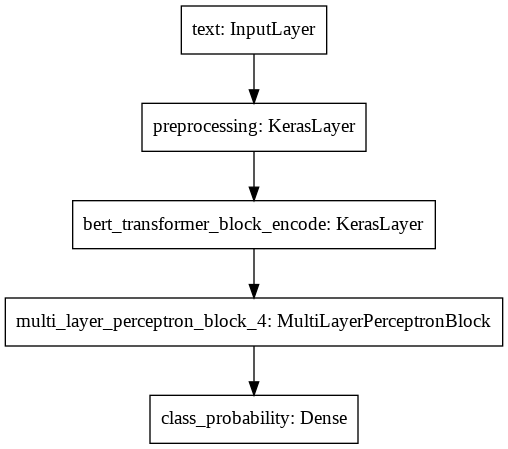

In [51]:
# Visualise the computation graph for our model
tf.keras.utils.plot_model(bert_mlp_ner_classifier)

## Optimisation

In terms of optimisation, we will be using categorical cross entropy given that the objective is to predict NER and that is single label classification. 

In [52]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.metrics.Precision(),
           tf.metrics.Recall(),
           tf.keras.metrics.Accuracy(),
           loss]

In [58]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_batch).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [61]:
bert_mlp_ner_classifier.compile(optimizer=optimizer,
                         loss='sparse_categorical_crossentropy',
                         metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

##  Train Model

In [ ]:
history = bert_mlp_ner_classifier.fit(x=train_batch,
                               validation_data=val_batch,
                               epochs=5)

Epoch 1/5
     81/Unknown - 611s 8s/step - loss: 2.6233 - sparse_categorical_accuracy: 0.1435